En este archivo haremos un análisis exploratorio preliminar de los viajes de los "High Volume For-Hire Vehicle (HVFHV)" para el __primer semestre__ del año __2022__. Esta categoría empezó a aplicarse en Febrero de 2019 en NYC a vehículos con más de 10000 viajes por día.

In [59]:
import modin.pandas as pd
from distributed import Client
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# Inicializa un cliente Dask para la ejecución distribuida en múltiples núcleos
client = Client(memory_limit='8GB')

In [2]:
tlc_22_01 = pd.read_parquet("../raw_data/fhvhv_tripdata_2022-01.parquet")
tlc_22_02 = pd.read_parquet("../raw_data/fhvhv_tripdata_2022-02.parquet")
tlc_22_03 = pd.read_parquet("../raw_data/fhvhv_tripdata_2022-03.parquet")
tlc_22_04 = pd.read_parquet("../raw_data/fhvhv_tripdata_2022-04.parquet")
tlc_22_05 = pd.read_parquet("../raw_data/fhvhv_tripdata_2022-05.parquet")
tlc_22_06 = pd.read_parquet("../raw_data/fhvhv_tripdata_2022-06.parquet")

In [3]:
# Todos los dataframes del primer semestre de 2022.
tlc_22_S1 = [tlc_22_01, tlc_22_02, tlc_22_03, tlc_22_04, tlc_22_05, tlc_22_06]

## Estructura general

In [5]:
tlc_22_01.dtypes

hvfhs_license_num               object
dispatching_base_num            object
originating_base_num            object
request_datetime        datetime64[ns]
on_scene_datetime       datetime64[ns]
pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
PULocationID                     int64
DOLocationID                     int64
trip_miles                     float64
trip_time                        int64
base_passenger_fare            float64
tolls                          float64
bcf                            float64
sales_tax                      float64
congestion_surcharge           float64
airport_fee                    float64
tips                           float64
driver_pay                     float64
shared_request_flag             object
shared_match_flag               object
access_a_ride_flag              object
wav_request_flag                object
wav_match_flag                  object
dtype: object

Hay 24 columnas:
* 4 de tipo datetime.
* 9 de tipo float.
* 3 de tipo int.
* 8 de tipo object.

In [7]:
for df in tlc_22_S1:
    print(f"Filas: {df.shape[0]}")

Filas: 14751591
Filas: 16019283
Filas: 18453548
Filas: 17752561
Filas: 18157335
Filas: 17780075


In [122]:
tlc_22_01.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2022-01-01 00:05:31,2022-01-01 00:05:40,2022-01-01 00:07:24,2022-01-01 00:18:28,170,161,1.18,664,2.21,2.75,0.0,0.0,23.03,N,N,,N,N
1,HV0003,B03404,B03404,2022-01-01 00:19:27,2022-01-01 00:22:08,2022-01-01 00:22:32,2022-01-01 00:30:12,237,161,0.82,460,1.06,2.75,0.0,0.0,12.32,N,N,,N,N
2,HV0003,B03404,B03404,2022-01-01 00:43:53,2022-01-01 00:57:37,2022-01-01 00:57:37,2022-01-01 01:07:32,237,161,1.18,595,2.65,2.75,0.0,0.0,23.30,N,N,,N,N
3,HV0003,B03404,B03404,2022-01-01 00:15:36,2022-01-01 00:17:08,2022-01-01 00:18:02,2022-01-01 00:23:05,262,229,1.65,303,0.70,2.75,0.0,0.0,6.30,N,N,,N,N
4,HV0003,B03404,B03404,2022-01-01 00:25:45,2022-01-01 00:26:01,2022-01-01 00:28:01,2022-01-01 00:35:42,229,141,1.65,461,0.84,2.75,0.0,0.0,7.44,N,N,,N,N


## Duplicados

Vamos a analizar la presencia de duplicados. Al haber tantas columnas, vamos a elegir un subset representativo. En caso de encontrar duplicados aplicaremos distintas estrategias.

In [4]:
#tlc_22_01.duplicated(subset=["pickup_datetime", "dropoff_datetime", 
#                             "PULocationID", "DOLocationID", "trip_miles"]).sum()

0

In [4]:
#tlc_22_02.duplicated(subset=["pickup_datetime", "dropoff_datetime", 
#                             "PULocationID", "DOLocationID", "trip_miles"]).sum()

0

In [4]:
#tlc_22_03.duplicated(subset=["pickup_datetime", "dropoff_datetime", 
#                             "PULocationID", "DOLocationID", "trip_miles"]).sum()

0

In [4]:
#tlc_22_04.duplicated(subset=["pickup_datetime", "dropoff_datetime", 
#                             "PULocationID", "DOLocationID", "trip_miles"]).sum()

0

In [4]:
#tlc_22_05.duplicated(subset=["pickup_datetime", "dropoff_datetime", 
#                             "PULocationID", "DOLocationID", "trip_miles"]).sum()

2075

Al haber encontrado 2075 duplicados en este subset, analizaremos todo el conjunto de datos.

In [4]:
#tlc_22_05.duplicated().sum()

1872

En efecto, encontramos 1872 duplicados en mayo de 2022.

In [4]:
#tlc_22_06.duplicated(subset=["pickup_datetime", "dropoff_datetime", 
#                             "PULocationID", "DOLocationID", "trip_miles"]).sum()

0

## hvfhs_license_num

In [26]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.hvfhs_license_num.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [27]:
for df in tlc_22_S1:
    print(f"Los valores únicos por mes: "
          f"{df.hvfhs_license_num.unique()}")

Los valores únicos por mes: ['HV0003' 'HV0005']
Los valores únicos por mes: ['HV0003' 'HV0005']
Los valores únicos por mes: ['HV0003' 'HV0005']
Los valores únicos por mes: ['HV0003' 'HV0005']
Los valores únicos por mes: ['HV0003' 'HV0005']
Los valores únicos por mes: ['HV0003' 'HV0005']


In [28]:
for df in tlc_22_S1:
    print(df.hvfhs_license_num.value_counts(normalize=True), "\n")

hvfhs_license_num
HV0003    0.73391
HV0005    0.26609
Name: proportion, dtype: float64 

hvfhs_license_num
HV0003    0.714195
HV0005    0.285805
Name: proportion, dtype: float64 

hvfhs_license_num
HV0003    0.711856
HV0005    0.288144
Name: proportion, dtype: float64 

hvfhs_license_num
HV0003    0.732907
HV0005    0.267093
Name: proportion, dtype: float64 

hvfhs_license_num
HV0003    0.733887
HV0005    0.266113
Name: proportion, dtype: float64 

hvfhs_license_num
HV0003    0.73396
HV0005    0.26604
Name: proportion, dtype: float64 



Entre el 71-73% de las licencias corresponden a HV0003 (Uber) mientras que el 26-28% de las licencias restantes corresponden a HV0005 (Lyft).

## dispatching_base_num

In [29]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.dispatching_base_num.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [30]:
for df in tlc_22_S1:
    print(f"Los valores únicos por mes: "
          f"{sorted(df.dispatching_base_num.unique())}")

Los valores únicos por mes: ['B02395', 'B02512', 'B02617', 'B02682', 'B02764', 'B02765', 'B02835', 'B02864', 'B02866', 'B02867', 'B02869', 'B02870', 'B02871', 'B02872', 'B02875', 'B02876', 'B02877', 'B02878', 'B02879', 'B02880', 'B02882', 'B02883', 'B02884', 'B02887', 'B02888', 'B02889', 'B03404', 'B03406']
Los valores únicos por mes: ['B02395', 'B02512', 'B02617', 'B02682', 'B02764', 'B02765', 'B02835', 'B02864', 'B02865', 'B02866', 'B02867', 'B02869', 'B02870', 'B02871', 'B02872', 'B02875', 'B02876', 'B02877', 'B02878', 'B02879', 'B02880', 'B02882', 'B02883', 'B02884', 'B02887', 'B02888', 'B02889', 'B03404', 'B03406']
Los valores únicos por mes: ['B02395', 'B02512', 'B02617', 'B02682', 'B02764', 'B02765', 'B02835', 'B02864', 'B02866', 'B02867', 'B02869', 'B02870', 'B02871', 'B02872', 'B02876', 'B02877', 'B02879', 'B02880', 'B02882', 'B02884', 'B02887', 'B02888', 'B02889', 'B03404', 'B03406']
Los valores únicos por mes: ['B02395', 'B02512', 'B02617', 'B02682', 'B02764', 'B02765', 'B02

Cada base está asociada con una compañía distinta.

## originating_base_num

In [31]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.originating_base_num.isna().mean()}")

Promedio de nulos por mes: 0.26586766132548006
Promedio de nulos por mes: 0.28552395260137425
Promedio de nulos por mes: 0.2878502822329885
Promedio de nulos por mes: 0.2668087156551666
Promedio de nulos por mes: 0.26577132602333986
Promedio de nulos por mes: 0.2656660334672379


Hay un promedio de 26-28% de valores faltantes en esta columna.

In [32]:
for df in tlc_22_S1:
    print(f"Los valores únicos por mes: "
          f"{df.originating_base_num.unique()}")

Los valores únicos por mes: ['B03404' None 'B02764' 'B02395' 'B02889' 'B03406' 'B02878' 'B02867'
 'B02512' 'B02872' 'B02879' 'B02864' 'B02765' 'B02617' 'B02870' 'B02880'
 'B02882' 'B03153' 'B02876' 'B02877' 'B02682' 'B02887' 'B02869' 'B02884'
 'B02026' 'B02888' 'B02866' 'B02875' 'B02835' 'B02871' 'B02883']
Los valores únicos por mes: ['B03404' None 'B02889' 'B02682' 'B03406' 'B02764' 'B02887' 'B02869'
 'B02878' 'B02872' 'B02888' 'B02882' 'B02765' 'B02395' 'B02870' 'B02876'
 'B02884' 'B02864' 'B02867' 'B02835' 'B03153' 'B02877' 'B02871' 'B02026'
 'B02512' 'B02617' 'B02880' 'B02866' 'B02883' 'B02875' 'B00446' 'B02865'
 'B00887' 'B02879' 'B01985']
Los valores únicos por mes: ['B03404' None 'B02764' 'B02889' 'B03406' 'B02887' 'B02867' 'B02864'
 'B02395' 'B02876' 'B02872' 'B02882' 'B02869' 'B02765' 'B02870' 'B02888'
 'B02884' 'B02880' 'B02835' 'B02026' 'B02617' 'B02871' 'B02512' 'B00887'
 'B02877' 'B02682' 'B02866' 'B03153' 'B02879' 'B01985']
Los valores únicos por mes: ['B03404' None 'B027

## request_datetime

In [33]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.request_datetime.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [34]:
for df in tlc_22_S1:
    print(f"La descripción de cada mes es: "
          f"{df.request_datetime.describe()}\n")

La descripción de cada mes es: count                         14751591
mean     2022-01-17 00:44:22.792681216
min                2021-12-31 22:55:05
25%                2022-01-09 12:33:39
50%                2022-01-17 00:05:29
75%                2022-01-24 09:31:53
max                2022-02-01 00:10:03
Name: request_datetime, dtype: object

La descripción de cada mes es: count                         16019283
mean     2022-02-15 06:13:04.298686208
min                2022-01-31 23:14:00
25%                2022-02-08 07:49:34
50%                2022-02-15 03:38:08
75%                2022-02-22 07:49:00
max                2022-03-01 00:10:00
Name: request_datetime, dtype: object

La descripción de cada mes es: count                         18453548
mean     2022-03-16 14:27:16.539086848
min                2022-02-28 23:43:07
25%                2022-03-08 22:49:22
50%                2022-03-16 16:53:00
75%                2022-03-24 13:32:20
max                2022-04-01 00:10:00
Name: requ

No se observan outliers. Los valores extremos se superponen entre meses en algunos casos.

## on_scene_datetime

In [35]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.on_scene_datetime.isna().mean()}")

Promedio de nulos por mes: 0.2658463754858713
Promedio de nulos por mes: 0.2855206440887523
Promedio de nulos por mes: 0.28784675987511993
Promedio de nulos por mes: 0.26679739334510666
Promedio de nulos por mes: 0.26577132602333986
Promedio de nulos por mes: 0.26566586473904075


Hay un promedio de 26-28% de valores faltantes en esta columna.

In [36]:
for df in tlc_22_S1:
    print(f"La descripción de cada mes es: "
          f"{df.on_scene_datetime.describe()}\n")

La descripción de cada mes es: count                         10829934
mean     2022-01-17 01:20:23.351318272
min                2021-12-31 23:28:59
25%                2022-01-09 12:48:22
50%                2022-01-17 00:09:10
75%      2022-01-24 10:54:08.750000128
max                2022-01-31 23:59:54
Name: on_scene_datetime, dtype: object

La descripción de cada mes es: count                         11445447
mean     2022-02-15 04:16:36.721908736
min                2022-01-31 23:28:09
25%         2022-02-08 05:59:46.500000
50%                2022-02-14 23:10:36
75%                2022-02-22 00:55:53
max                2022-02-28 23:59:54
Name: on_scene_datetime, dtype: object

La descripción de cada mes es: count                         13141754
mean     2022-03-16 16:42:38.418733824
min                2022-02-28 23:28:06
25%                2022-03-09 02:28:39
50%                2022-03-16 19:51:32
75%                2022-03-24 15:46:44
max                2022-03-31 23:59:59
Name: on

No se observan outliers. Los valores extremos se superponen entre meses en algunos casos.

In [37]:
## pickup_datetime

In [38]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.pickup_datetime.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [39]:
for df in tlc_22_S1:
    print(f"La descripción de cada mes es: "
          f"{df.pickup_datetime.describe()}\n")

La descripción de cada mes es: count                         14751591
mean     2022-01-17 00:48:44.906158336
min                2022-01-01 00:00:00
25%                2022-01-09 12:37:09
50%                2022-01-17 00:12:20
75%                2022-01-24 09:35:22
max                2022-01-31 23:59:59
Name: pickup_datetime, dtype: object

La descripción de cada mes es: count                         16019283
mean     2022-02-15 06:17:49.111631872
min                2022-02-01 00:00:00
25%                2022-02-08 07:55:30
50%                2022-02-15 03:42:32
75%         2022-02-22 07:52:31.500000
max                2022-02-28 23:59:59
Name: pickup_datetime, dtype: object

La descripción de cada mes es: count                         18453548
mean     2022-03-16 14:32:01.984615936
min                2022-03-01 00:00:00
25%                2022-03-08 22:54:23
50%         2022-03-16 16:57:24.500000
75%                2022-03-24 13:35:59
max                2022-03-31 23:59:59
Name: pickup

No se observan outliers ni superposiciones entre los meses.

## dropoff_datetime

In [40]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.dropoff_datetime.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [41]:
for df in tlc_22_S1:
    print(f"La descripción de cada mes es: "
          f"{df.dropoff_datetime.describe()}\n")

La descripción de cada mes es: count                         14751591
mean     2022-01-17 01:05:39.393140992
min                2022-01-01 00:02:49
25%                2022-01-09 12:52:39
50%                2022-01-17 00:27:14
75%                2022-01-24 09:53:59
max                2022-02-01 07:21:13
Name: dropoff_datetime, dtype: object

La descripción de cada mes es: count                         16019283
mean     2022-02-15 06:36:13.446455808
min                2022-02-01 00:03:21
25%         2022-02-08 08:14:39.500000
50%                2022-02-15 03:57:24
75%         2022-02-22 08:10:30.500000
max                2022-03-01 03:46:39
Name: dropoff_datetime, dtype: object

La descripción de cada mes es: count                         18453548
mean     2022-03-16 14:50:56.415932928
min                2022-03-01 00:02:18
25%                2022-03-08 23:11:21
50%                2022-03-16 17:21:48
75%                2022-03-24 13:55:24
max                2022-04-01 04:00:02
Name: drop

No se observan outliers. Los valores extremos se superponen entre meses en algunos casos.

## PULocationID

In [42]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.PULocationID.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [52]:
for df in tlc_22_S1:
    print(f"El número de zonas únicas de cada mes es: "
          f"{df.PULocationID.nunique()}")

El número de zonas únicas de cada mes es: 260
El número de zonas únicas de cada mes es: 262
El número de zonas únicas de cada mes es: 263
El número de zonas únicas de cada mes es: 262
El número de zonas únicas de cada mes es: 262
El número de zonas únicas de cada mes es: 261


Es la zona de taxi TLC donde inició el viaje. Hay 265 en total.

In [50]:
for df in tlc_22_S1:
    print(f"Mínimo: {df.PULocationID.min()}, Máximo {df.PULocationID.max()}")

Mínimo: 2, Máximo 265
Mínimo: 1, Máximo 265
Mínimo: 1, Máximo 265
Mínimo: 1, Máximo 265
Mínimo: 1, Máximo 265
Mínimo: 2, Máximo 265


No se observan outliers en esta columna.

## DOLocationID

In [51]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.DOLocationID.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [53]:
for df in tlc_22_S1:
    print(f"El número de zonas únicas de cada mes es: "
          f"{df.DOLocationID.nunique()}")

El número de zonas únicas de cada mes es: 261
El número de zonas únicas de cada mes es: 261
El número de zonas únicas de cada mes es: 261
El número de zonas únicas de cada mes es: 261
El número de zonas únicas de cada mes es: 262
El número de zonas únicas de cada mes es: 262


Es la zona de taxi TLC donde culminó el viaje. Hay 265 en total.

In [54]:
for df in tlc_22_S1:
    print(f"Mínimo: {df.DOLocationID.min()}, Máximo {df.DOLocationID.max()}")

Mínimo: 1, Máximo 265
Mínimo: 1, Máximo 265
Mínimo: 1, Máximo 265
Mínimo: 1, Máximo 265
Mínimo: 1, Máximo 265
Mínimo: 1, Máximo 265


No se observan outliers en esta columna.

## trip_miles

In [55]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.trip_miles.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [56]:
for df in tlc_22_S1:
    print(f"La descripción de cada mes es: "
          f"{df.trip_miles.describe()}\n")

La descripción de cada mes es: count    1.475159e+07
mean     4.632833e+00
std      5.312836e+00
min      0.000000e+00
25%      1.520000e+00
50%      2.810000e+00
75%      5.710000e+00
max      4.407100e+02
Name: trip_miles, dtype: float64

La descripción de cada mes es: count    1.601928e+07
mean     4.735295e+00
std      5.383119e+00
min      0.000000e+00
25%      1.556000e+00
50%      2.880000e+00
75%      5.850000e+00
max      4.967100e+02
Name: trip_miles, dtype: float64

La descripción de cada mes es: count    1.845355e+07
mean     4.915850e+00
std      5.668483e+00
min      0.000000e+00
25%      1.589000e+00
50%      2.960000e+00
75%      6.072000e+00
max      6.287000e+02
Name: trip_miles, dtype: float64

La descripción de cada mes es: count    1.775256e+07
mean     5.066052e+00
std      5.827009e+00
min      0.000000e+00
25%      1.640000e+00
50%      3.070000e+00
75%      6.300000e+00
max      6.163100e+02
Name: trip_miles, dtype: float64

La descripción de cada mes es: count

Las distancias de 0 millas parecen ser errores. Veamos algunos ejemplos.

In [58]:
tlc_22_01[tlc_22_01.trip_miles == 0].head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
6860,HV0003,B03404,B03404,2021-12-31 23:30:58,2022-01-01 00:04:38,2022-01-01 00:04:38,2022-01-01 00:05:40,161,161,0.0,...,0.70,2.75,0.0,0.0,7.97,N,N,,N,N
9843,HV0003,B03404,B03404,2022-01-01 00:19:20,2022-01-01 00:25:06,2022-01-01 00:31:10,2022-01-01 00:35:13,210,210,0.0,...,0.88,0.00,0.0,0.0,0.00,N,N,,N,N
11155,HV0003,B03404,B03404,2022-01-01 00:24:27,2022-01-01 00:25:52,2022-01-01 00:25:52,2022-01-01 00:28:07,48,48,0.0,...,0.92,2.75,0.0,0.0,7.23,N,N,,N,N
14012,HV0003,B03404,B03404,2022-01-01 00:12:42,2022-01-01 00:12:53,2022-01-01 00:12:53,2022-01-01 00:13:49,174,174,0.0,...,0.64,0.00,0.0,0.0,7.60,N,N,,N,Y
14024,HV0003,B03404,B03404,2022-01-01 00:44:41,2022-01-01 00:49:55,2022-01-01 00:51:55,2022-01-01 00:57:32,4,4,0.0,...,1.00,2.75,0.0,0.0,8.83,N,N,,N,N


Vemos que en general son viajes cortos, dentro del mismo burough. Pueden ser errores o pueden ser viajes menores a 0,1 millas (160 m). Vamos a analizar outliers.

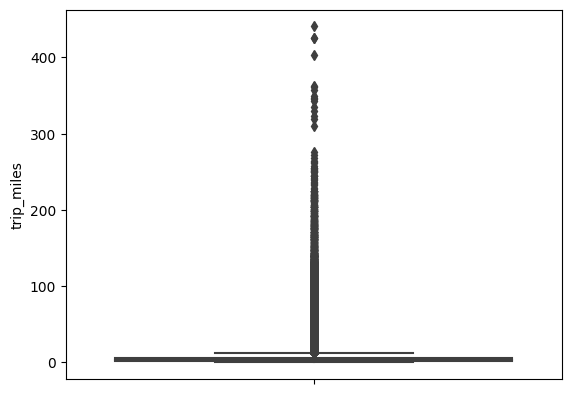

In [63]:
sns.boxplot(data = tlc_22_01, y="trip_miles");

Se observan numerosos outliers por este método. Quedará determinar si corresponde a errores o es debido a la dispersión de los datos. La superficie de NYC es de aproximadamente 468 millas cuadradas.

## trip_time

In [64]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.trip_time.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [65]:
for df in tlc_22_S1:
    print(f"La descripción de cada mes es: "
          f"{df.trip_time.describe()}\n")

La descripción de cada mes es: count    1.475159e+07
mean     1.020126e+03
std      6.874427e+02
min      0.000000e+00
25%      5.490000e+02
50%      8.510000e+02
75%      1.303000e+03
max      1.479180e+05
Name: trip_time, dtype: float64

La descripción de cada mes es: count    1.601928e+07
mean     1.104385e+03
std      7.632796e+02
min      0.000000e+00
25%      5.790000e+02
50%      9.110000e+02
75%      1.412000e+03
max      9.858900e+04
Name: trip_time, dtype: float64

La descripción de cada mes es: count    1.845355e+07
mean     1.133107e+03
std      7.871693e+02
min      1.000000e+00
25%      5.910000e+02
50%      9.330000e+02
75%      1.449000e+03
max      4.987500e+04
Name: trip_time, dtype: float64

La descripción de cada mes es: count    1.775256e+07
mean     1.161346e+03
std      8.214458e+02
min      0.000000e+00
25%      6.000000e+02
50%      9.510000e+02
75%      1.482000e+03
max      4.329800e+04
Name: trip_time, dtype: float64

La descripción de cada mes es: count    

Tiempos de viaje de 0 segundos podrían ser errores. Veamos algunos casos.

In [74]:
tlc_22_01[tlc_22_01.trip_time == 0].head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
10279851,HV0003,B03404,B03404,2022-01-22 20:39:50,2022-01-22 20:40:23,2022-01-22 20:40:23,2022-01-22 20:40:23,146,146,0.01,0,0.64,0.0,0.0,0.0,0.0,N,N,,N,N


Hay solo 5 casos en el primer semestre de 2022. Y el pickup_time coincide con el dropoff_time, por lo que es factible que se trate de errores. Hagamos un análisis preliminar de outliers.

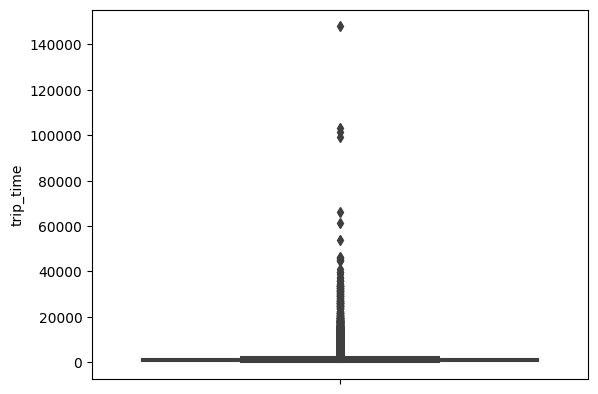

In [75]:
sns.boxplot(data = tlc_22_01, y="trip_time");

También se observan numerosos outliers que corresponderá estudiar. Probablemente aquellos en el orden de 140000 segundos (aprox. 39 horas) sean errores.

## base_passenger_fare

In [77]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.base_passenger_fare.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [79]:
for df in tlc_22_S1:
    print(f"La descripción de cada mes es: "
          f"{df.base_passenger_fare.describe()}\n")

La descripción de cada mes es: count    1.475159e+07
mean     1.965113e+01
std      1.546124e+01
min     -3.486100e+02
25%      9.860000e+00
50%      1.541000e+01
75%      2.400000e+01
max      4.995960e+03
Name: base_passenger_fare, dtype: float64

La descripción de cada mes es: count    1.601928e+07
mean     2.111823e+01
std      1.642853e+01
min     -5.201100e+02
25%      1.068000e+01
50%      1.679000e+01
75%      2.593000e+01
max      2.024730e+03
Name: base_passenger_fare, dtype: float64

La descripción de cada mes es: count    1.845355e+07
mean     2.245641e+01
std      1.813076e+01
min     -5.012500e+02
25%      1.120000e+01
50%      1.745000e+01
75%      2.751000e+01
max      3.356700e+03
Name: base_passenger_fare, dtype: float64

La descripción de cada mes es: count    1.775256e+07
mean     2.406397e+01
std      1.949136e+01
min     -5.108200e+02
25%      1.187000e+01
50%      1.883000e+01
75%      2.976000e+01
max      3.732900e+03
Name: base_passenger_fare, dtype: float64



Las tarifas negativas probablemente sean errores. Aquellas tarifas en el orden de 10^3, también es posible que sean errores, por alejarse del resto de los cuartilos. Hagamos un análisis preliminar de outliers.

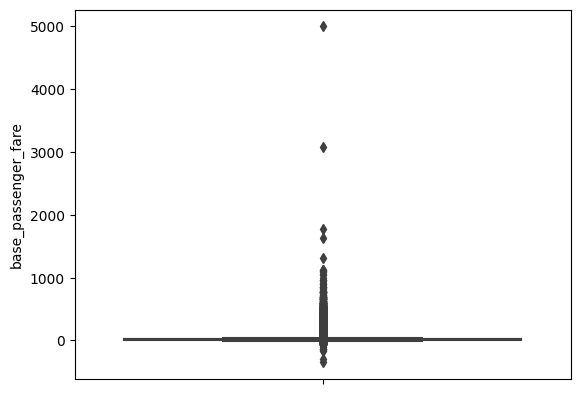

In [83]:
sns.boxplot(data = tlc_22_01, y="base_passenger_fare");

Se observan numerosos outliers por este método, por lo que corresponderá revisar si corresponden a errores en los datos o no.

## tolls

In [84]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.tolls.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [85]:
for df in tlc_22_S1:
    print(f"La descripción de cada mes es: "
          f"{df.tolls.describe()}\n")

La descripción de cada mes es: count    1.475159e+07
mean     8.979449e-01
std      3.414747e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.045800e+02
Name: tolls, dtype: float64

La descripción de cada mes es: count    1.601928e+07
mean     9.926226e-01
std      3.582191e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.353200e+02
Name: tolls, dtype: float64

La descripción de cada mes es: count    1.845355e+07
mean     1.080624e+00
std      3.727734e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.413600e+02
Name: tolls, dtype: float64

La descripción de cada mes es: count    1.775256e+07
mean     1.128932e+00
std      3.810842e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.623300e+02
Name: tolls, dtype: float64

La descripción de cada mes es: count    1.815734e+07
mea

Los valores mínimos de 0 son factibles. Hagamos un análisis preliminar de outliers para ver los superiores.

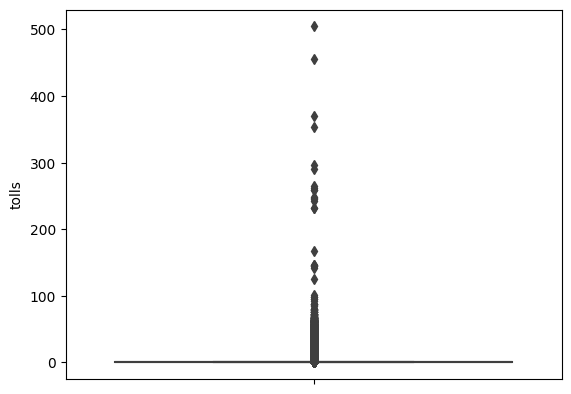

In [86]:
sns.boxplot(data = tlc_22_01, y="tolls");

Según este método, hay outliers por encima del bigote superior. Queda determinar si son errores o se deben a la distribución de los datos.

## bcf

In [87]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.bcf.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [88]:
for df in tlc_22_S1:
    print(f"La descripción de cada mes es: "
          f"{df.bcf.describe()}\n")

La descripción de cada mes es: count    1.475159e+07
mean     6.217636e-01
std      5.278451e-01
min      0.000000e+00
25%      3.000000e-01
50%      4.700000e-01
75%      7.400000e-01
max      1.645600e+02
Name: bcf, dtype: float64

La descripción de cada mes es: count    1.601928e+07
mean     6.671241e-01
std      5.589842e-01
min      0.000000e+00
25%      3.200000e-01
50%      5.100000e-01
75%      8.100000e-01
max      9.721000e+01
Name: bcf, dtype: float64

La descripción de cada mes es: count    1.845355e+07
mean     7.115143e-01
std      6.144951e-01
min      0.000000e+00
25%      3.400000e-01
50%      5.300000e-01
75%      8.600000e-01
max      1.015000e+02
Name: bcf, dtype: float64

La descripción de cada mes es: count    1.775256e+07
mean     7.615644e-01
std      6.583965e-01
min      0.000000e+00
25%      3.600000e-01
50%      5.700000e-01
75%      9.300000e-01
max      1.125400e+02
Name: bcf, dtype: float64

La descripción de cada mes es: count    1.815734e+07
mean     8.

Los valores mínimos de 0 son factibles. Hagamos un análisis preliminar de outliers para ver los superiores.

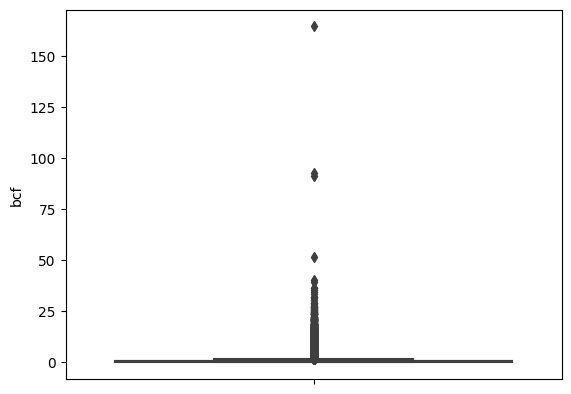

In [89]:
sns.boxplot(data = tlc_22_01, y="bcf");

Según este método, hay outliers por encima del bigote superior. Queda determinar si son errores o se deben a la distribución de los datos.

## sales_tax

In [90]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.sales_tax.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [91]:
for df in tlc_22_S1:
    print(f"La descripción de cada mes es: "
          f"{df.sales_tax.describe()}\n")

La descripción de cada mes es: count    1.475159e+07
mean     1.707564e+00
std      1.321465e+00
min      0.000000e+00
25%      8.500000e-01
50%      1.340000e+00
75%      2.110000e+00
max      4.868300e+02
Name: sales_tax, dtype: float64

La descripción de cada mes es: count    1.601928e+07
mean     1.820186e+00
std      1.402277e+00
min      0.000000e+00
25%      9.000000e-01
50%      1.440000e+00
75%      2.270000e+00
max      2.875800e+02
Name: sales_tax, dtype: float64

La descripción de cada mes es: count    1.845355e+07
mean     1.922551e+00
std      1.520730e+00
min      0.000000e+00
25%      9.500000e-01
50%      1.500000e+00
75%      2.390000e+00
max      2.468400e+02
Name: sales_tax, dtype: float64

La descripción de cada mes es: count    1.775256e+07
mean     2.052402e+00
std      1.630296e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.610000e+00
75%      2.600000e+00
max      3.329400e+02
Name: sales_tax, dtype: float64

La descripción de cada mes es: count    

Los valores mínimos de 0 son factibles. Hagamos un análisis preliminar de outliers para ver los superiores.

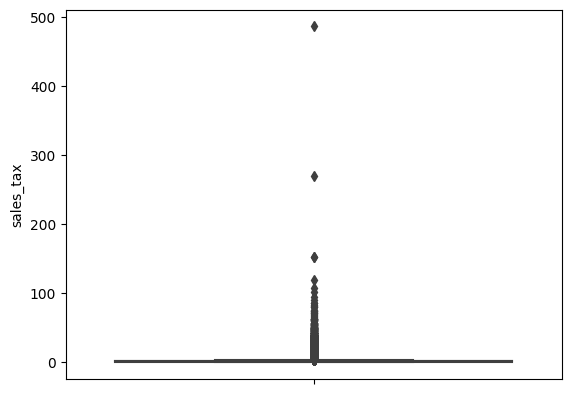

In [92]:
sns.boxplot(data = tlc_22_01, y="sales_tax");

Según este método, hay outliers por encima del bigote superior. Queda determinar si son errores o se deben a la distribución de los datos.

## congestion_surcharge

In [93]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.congestion_surcharge.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [94]:
for df in tlc_22_S1:
    print(f"La descripción de cada mes es: "
          f"{df.congestion_surcharge.describe()}\n")

La descripción de cada mes es: count    1.475159e+07
mean     1.079914e+00
std      1.351230e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.750000e+00
max      1.100000e+01
Name: congestion_surcharge, dtype: float64

La descripción de cada mes es: count    1.601928e+07
mean     1.160580e+00
std      1.371841e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.750000e+00
max      8.250000e+00
Name: congestion_surcharge, dtype: float64

La descripción de cada mes es: count    1.845355e+07
mean     1.150462e+00
std      1.359441e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.750000e+00
max      1.100000e+01
Name: congestion_surcharge, dtype: float64

La descripción de cada mes es: count    1.775256e+07
mean     1.166918e+00
std      1.361159e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.750000e+00
max      1.100000e+01
Name: congestion_surcharge, dtype: float

Los valores mínimos de 0 son factibles. Hagamos un análisis preliminar de outliers para ver los superiores.

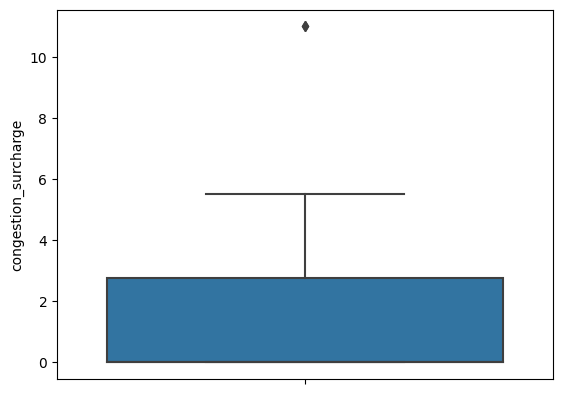

In [95]:
sns.boxplot(data = tlc_22_01, y="congestion_surcharge");

Se observan outliers por encima del bigote superior. No obstante, dado los valores absolutos, no parecen ser errores.

## airport_fee

In [96]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.airport_fee.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [98]:
for df in tlc_22_S1:
    print(f"La descripción de cada mes es: "
          f"{df.airport_fee.describe()}\n")

La descripción de cada mes es: count    1.475159e+07
mean     1.470887e-01
std      5.920917e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.400000e+00
Name: airport_fee, dtype: float64

La descripción de cada mes es: count    1.601928e+07
mean     1.542164e-01
std      6.045528e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.400000e+00
Name: airport_fee, dtype: float64

La descripción de cada mes es: count    1.845355e+07
mean     1.822664e-01
std      6.537316e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.900000e+00
Name: airport_fee, dtype: float64

La descripción de cada mes es: count    1.775256e+07
mean     1.977550e-01
std      6.814153e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.500000e+00
Name: airport_fee, dtype: float64

La descripción de cada mes es: c

Los valores mínimos de 0 son factibles. Hagamos un análisis preliminar de outliers para ver los superiores.

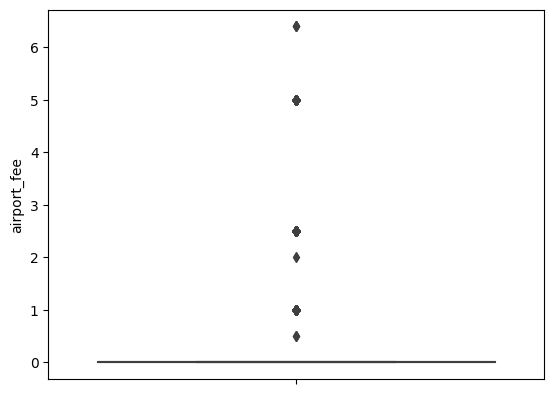

In [99]:
sns.boxplot(data = tlc_22_01, y="airport_fee");

Se observan outliers por encima del bigote superior. No obstante, dado los valores absolutos, no parecen ser errores.

## tips

In [100]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.tips.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [101]:
for df in tlc_22_S1:
    print(f"La descripción de cada mes es: "
          f"{df.tips.describe()}\n")

La descripción de cada mes es: count    1.475159e+07
mean     8.065149e-01
std      2.448188e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.031600e+02
Name: tips, dtype: float64

La descripción de cada mes es: count    1.601928e+07
mean     8.910467e-01
std      2.588551e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+02
Name: tips, dtype: float64

La descripción de cada mes es: count    1.845355e+07
mean     1.005846e+00
std      2.840926e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.700000e+02
Name: tips, dtype: float64

La descripción de cada mes es: count    1.775256e+07
mean     1.112949e+00
std      3.060867e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.670000e+02
Name: tips, dtype: float64

La descripción de cada mes es: count    1.815734e+07
mean   

Los valores mínimos de 0 son factibles. Hagamos un análisis preliminar de outliers para ver los superiores.

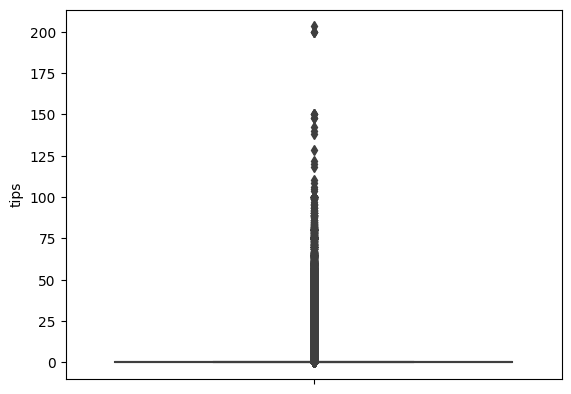

In [102]:
sns.boxplot(data = tlc_22_01, y="tips");

Según este método, hay outliers por encima del bigote superior. Queda determinar si son errores o se deben a la distribución de los datos.

## driver_pay

In [103]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.driver_pay.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [104]:
for df in tlc_22_S1:
    print(f"La descripción de cada mes es: "
          f"{df.driver_pay.describe()}\n")

La descripción de cada mes es: count    1.475159e+07
mean     1.563843e+01
std      1.231398e+01
min     -1.826400e+02
25%      7.680000e+00
50%      1.203000e+01
75%      1.941000e+01
max      4.643190e+03
Name: driver_pay, dtype: float64

La descripción de cada mes es: count    1.601928e+07
mean     1.643209e+01
std      1.309580e+01
min     -1.910000e+02
25%      7.820000e+00
50%      1.265000e+01
75%      2.053000e+01
max      1.707760e+03
Name: driver_pay, dtype: float64

La descripción de cada mes es: count    1.845355e+07
mean     1.807682e+01
std      1.445710e+01
min     -5.454000e+01
25%      8.720000e+00
50%      1.392000e+01
75%      2.248000e+01
max      2.006460e+03
Name: driver_pay, dtype: float64

La descripción de cada mes es: count    1.775256e+07
mean     1.902645e+01
std      1.530752e+01
min     -1.778000e+01
25%      9.070000e+00
50%      1.481000e+01
75%      2.392000e+01
max      2.053100e+03
Name: driver_pay, dtype: float64

La descripción de cada mes es: count

Los valores negativos es probable que sean errores. Haremos un análisis preliminar de outliers.

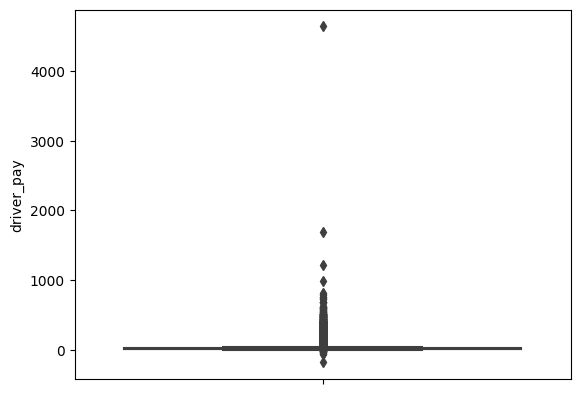

In [105]:
sns.boxplot(data = tlc_22_01, y="driver_pay");

Según este método, hay outliers por encima del bigote superior. Queda determinar si son errores o se deben a la distribución de los datos.

## shared_request_flag

In [106]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.shared_request_flag.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [107]:
for df in tlc_22_S1:
    print(f"Los valores únicos por mes: "
          f"{df.shared_request_flag.unique()}")

Los valores únicos por mes: ['N']
Los valores únicos por mes: ['N']
Los valores únicos por mes: ['N']
Los valores únicos por mes: ['N']
Los valores únicos por mes: ['N']
Los valores únicos por mes: ['N' 'Y']


En los primeros 5 meses del 2022, ningún pasajero solicitó compartir viaje. En junio de 2022, la proporción fue:

In [108]:
tlc_22_06.shared_request_flag.value_counts(normalize=True)

shared_request_flag
N    0.997599
Y    0.002401
Name: proportion, dtype: float64

## shared_match_flag

In [109]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.shared_match_flag.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [110]:
for df in tlc_22_S1:
    print(f"Los valores únicos por mes: "
          f"{df.shared_match_flag.unique()}")

Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']


In [111]:
for df in tlc_22_S1:
    print(df.shared_match_flag.value_counts(normalize=True), "\n")

shared_match_flag
N    0.999861
Y    0.000139
Name: proportion, dtype: float64 

shared_match_flag
N    0.999791
Y    0.000209
Name: proportion, dtype: float64 

shared_match_flag
N    0.999904
Y    0.000096
Name: proportion, dtype: float64 

shared_match_flag
N    0.999576
Y    0.000424
Name: proportion, dtype: float64 

shared_match_flag
N    0.999748
Y    0.000252
Name: proportion, dtype: float64 

shared_match_flag
N    0.999497
Y    0.000503
Name: proportion, dtype: float64 



En todos los meses, menos del 1% de los pasajeros compartieron viajes.

## access_a_ride_flag

In [112]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.access_a_ride_flag.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [113]:
for df in tlc_22_S1:
    print(f"Los valores únicos por mes: "
          f"{df.access_a_ride_flag.unique()}")

Los valores únicos por mes: [' ' 'N']
Los valores únicos por mes: [' ' 'N']
Los valores únicos por mes: [' ' 'N']
Los valores únicos por mes: [' ' 'N']
Los valores únicos por mes: [' ' 'N']
Los valores únicos por mes: [' ' 'N']


Según el diccionario de datos, esta columna puede tomar los valores 'Y' o 'N'. La presencia de un string vacio puede hablar de problemas en la calidad de los datos.

## wav_request_flag

In [114]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.wav_request_flag.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [115]:
for df in tlc_22_S1:
    print(f"Los valores únicos por mes: "
          f"{df.wav_request_flag.unique()}")

Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']


In [116]:
for df in tlc_22_S1:
    print(df.wav_request_flag.value_counts(normalize=True), "\n")

wav_request_flag
N    0.998947
Y    0.001053
Name: proportion, dtype: float64 

wav_request_flag
N    0.998904
Y    0.001096
Name: proportion, dtype: float64 

wav_request_flag
N    0.998723
Y    0.001277
Name: proportion, dtype: float64 

wav_request_flag
N    0.998774
Y    0.001226
Name: proportion, dtype: float64 

wav_request_flag
N    0.998768
Y    0.001232
Name: proportion, dtype: float64 

wav_request_flag
N    0.998734
Y    0.001266
Name: proportion, dtype: float64 



En todos los meses, menos del 1% de los pasajeros solicitaron vehículos accesibles para sillas de ruedas.

## wav_match_flag

In [117]:
for df in tlc_22_S1:
    print(f"Promedio de nulos por mes: "
          f"{df.wav_match_flag.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [118]:
for df in tlc_22_S1:
    print(f"Los valores únicos por mes: "
          f"{df.wav_match_flag.unique()}")

Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']


In [119]:
for df in tlc_22_S1:
    print(df.wav_match_flag.value_counts(normalize=True), "\n")

wav_match_flag
N    0.947551
Y    0.052449
Name: proportion, dtype: float64 

wav_match_flag
N    0.945698
Y    0.054302
Name: proportion, dtype: float64 

wav_match_flag
N    0.947841
Y    0.052159
Name: proportion, dtype: float64 

wav_match_flag
N    0.953088
Y    0.046912
Name: proportion, dtype: float64 

wav_match_flag
N    0.940603
Y    0.059397
Name: proportion, dtype: float64 

wav_match_flag
N    0.939914
Y    0.060086
Name: proportion, dtype: float64 



En todos los meses, entre el 4 y el 6% de los viajes sucedieron en vehículos accesibles para sillas de ruedas.